Celem projektu jest opracowanie sieci neuronowej która będzie optymalnie przypisywać prawdopodobieństwa przynależności do klas zdjęć planktonu z oetykietowanego datasetu wrzuconego na kaggle z okazji konkursu 'National Data Science Bowl' w 2015 roku..

Dane wejściowe: obrazki planktonu                                             
Dane wyjściowe: prawdopodobieństwo przynależności do danej klasy

Importy:

In [2]:
import os
import math
import random
import pathlib
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter
from emoji import emojize as emo
from matplotlib.colors import Normalize
from tensorflow.keras.layers import Layer
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix
from scipy.spatial.distance import squareform
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from DeepSeaLibrary import PlantktonPlot, create_tfrecord, load_dataset, Model, Metryka #Moja biblioteka

Nasz dataset zawiera zdecydowanie zbyt mało elementów niektórych klas. Chciałbym więc poszerzyć dostępne dla modelu dane poprzez augmentacje danych. Używać będę dostępnych w tensorflow.layers operacji (patrz Augmentation w ExplorationOfData.ipynb)
W tym problemie obrazki nie mają orientacji góra/dół więc możemy je dowolnie obracać

Najpierw chciałbym z zbadać jak mój oryginalny pomysł na sieć (trzy konwolucyjne i dwie gęste) ma się do nieco głębszych sieci, zarówno w sensie konwolucyjnym jak i gęstym. Polecenie model pozwala na ewentualne dodawanie +1 warstwy i dropoutu.

To teraz wczytajmy dane.
Niektóre klasy mają zdecydowanie za mało elementów. Będę stosować dość agresywną augmentacje danych więc mogę dopróbkować mój zbiór treningowy powtarzając niektóre przypadki. Augmentacja ukryta została w load_dataset.

In [3]:
train_path = r"C:\Users\spbki\Downloads\train\train"

# Weźmy wszystkie obrazki i etykietki
T_data = []
T_labels = []
V_data = []
V_labels = []
for label in os.listdir(train_path):
    data = []
    labels = []
    label_path = os.path.join(train_path, label)
    for file in os.listdir(label_path):
        data.append(os.path.join(label_path, file))
        labels.append(label)
    minsize = 400
    ln = len(data)*0.8 #walidacyjny to 0.2 nieduplikowalnych przypadków
    tr = int(math.floor(ln))
    V_data.extend(data[tr:])
    V_labels.extend(labels[tr:])
    T_data.extend(data[:tr]*min([int(math.ceil(minsize/ln)),5])) #opisywane wyżej dopróbkowywanie
    T_labels.extend(labels[:tr]*min([int(math.ceil(minsize/ln)),5])) #opisywane wyżej dopróbkowywanie
    #if int(math.ceil(minsize/ln)) > 1:
     #   print('Multiplying data for: ' + label +'! From ' + str(ln) + ', to ' + str(len(labels[:tr]*min([int(math.ceil(400/ln)),5]))))
print("Training set has this many examples: ")
print(len(T_labels))
# Kodowanie
label_encoder = LabelEncoder()
all_labels = list(set(T_labels + V_labels))
label_encoder.fit(all_labels)
T_encoded_labels = label_encoder.transform(T_labels)
# Szuflowanie
combined = list(zip(T_data, T_encoded_labels))
random.shuffle(combined)
T_data, T_labels = zip(*combined)
T_counts = list(Counter(T_labels).values())

V_encoded_labels = label_encoder.transform(V_labels)
# Szuflowanie
combined = list(zip(V_data, V_encoded_labels))
random.shuffle(combined)
V_data, V_labels = zip(*combined)
V_counts = list(Counter(V_labels).values())

Training set has this many examples: 
46686


In [194]:
create_tfrecord(T_data, T_labels, "train.tfrecord")
create_tfrecord(V_data, V_labels, "val.tfrecord")

In [195]:
T_ds = load_dataset("train.tfrecord", batch_size=16, training=True)
V_ds = load_dataset("val.tfrecord", batch_size=16, training=False)

Teraz zdefiniuje sobie callbacki

In [176]:
early_stop = EarlyStopping(
    monitor='val_loss',     # or 'val_accuracy' if you prefer
    patience=8,             # wait 5 epochs after last improvement
    restore_best_weights=True,  # roll back to best model
    verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',      # or 'val_accuracy'
    factor=0.5,              # reduce by a factor (e.g. 0.5 = halve it)
    patience=2,              # wait 3 epochs before reducing
    min_lr=1e-6,             # don’t go lower than this
    verbose=1
)

Teraz możemy przejść do badania architektury modelu. Sprawdźmy czy dodawanie warstw do naszego modelu ma sens. Nie ma chyba lepszej metody niż mozolny trening..

In [111]:
%%time
histories = [None] * 4
params = [(0, False, False, 121), (0, True, False, 121), (0, False, True, 121), (0, True, True, 121)]
with tf.device('/GPU:0'):
    for i, p in enumerate(params):
        print(p)
        if i > 0:
            break
        model = Model(*p)
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        history = model.fit(
            T_ds,
            validation_data=V_ds,
            epochs=50,
            callbacks=[early_stop, reduce_lr],
            verbose=1
        )
        histories[i] = history

(0, False, False, 121)
Epoch 1/50
2918/2918 [==============================] - 83s 27ms/step - loss: 3.6039 - accuracy: 0.1550 - val_loss: 9.1052 - val_accuracy: 0.0836 - lr: 0.0010
Epoch 2/50
2918/2918 [==============================] - 80s 27ms/step - loss: 2.6891 - accuracy: 0.2816 - val_loss: 9.8703 - val_accuracy: 0.0945 - lr: 0.0010
Epoch 3/50
2916/2918 [============================>.] - ETA: 0s - loss: 2.4134 - accuracy: 0.3373
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
2918/2918 [==============================] - 79s 27ms/step - loss: 2.4133 - accuracy: 0.3373 - val_loss: 454.3514 - val_accuracy: 0.0062 - lr: 0.0010
Epoch 4/50
2918/2918 [==============================] - 77s 26ms/step - loss: 2.1544 - accuracy: 0.3958 - val_loss: 4.3507 - val_accuracy: 0.2518 - lr: 5.0000e-04
Epoch 5/50
2918/2918 [==============================] - 78s 26ms/step - loss: 2.0439 - accuracy: 0.4234 - val_loss: 25.4291 - val_accuracy: 0.0307 - lr: 5.0000e-04
Epoch 6/

(0, False, False, 121) : 0.4058871567249298
(0, True, False, 121) : 0.31283727288246155
(0, False, True, 121) : 0.15061324834823608
(0, True, True, 121) : 0.6132461428642273


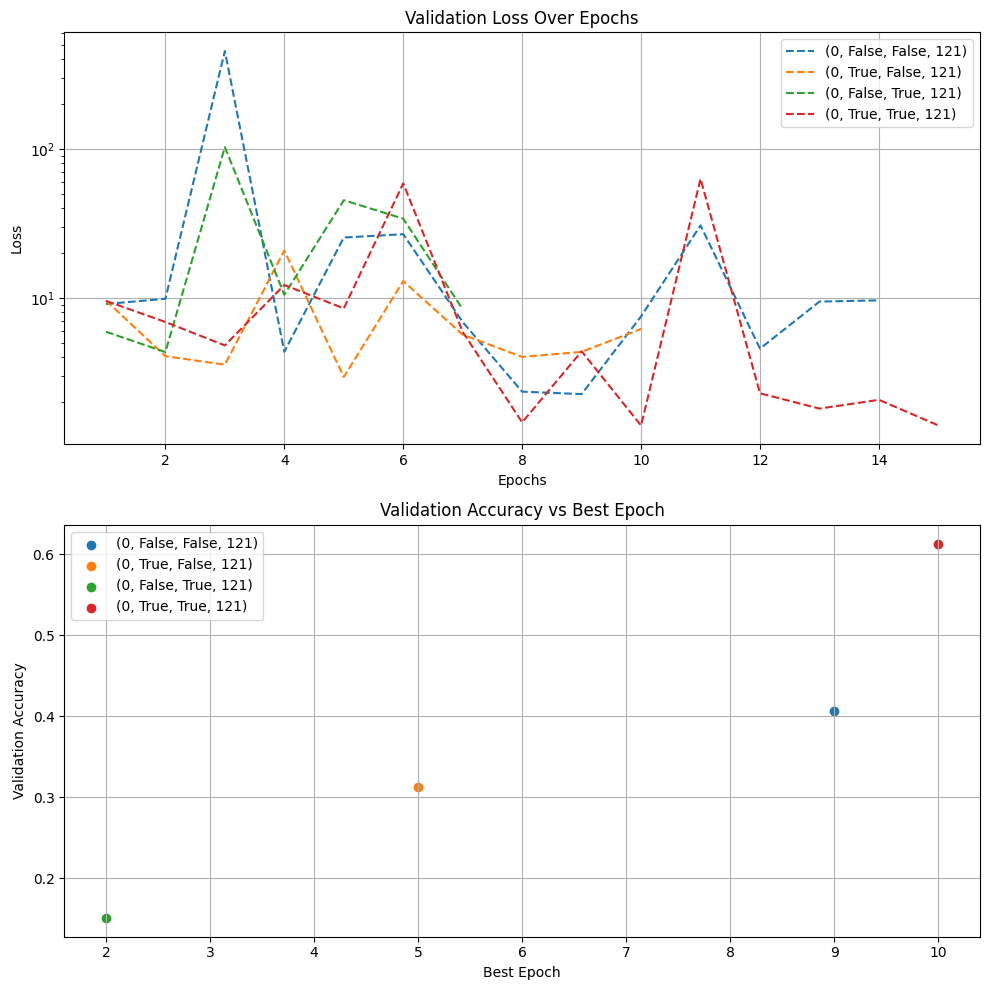

In [116]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))
for p, history in zip(params, histories):
    val_loss = history.history['val_loss']
    epochs = range(1, len(val_loss) + 1)
    axes[0].plot(epochs, val_loss, '--', label=str(p))
    print(str(p) + ' : ' + str(max(history.history['val_accuracy'])))

axes[0].set_title('Validation Loss Over Epochs')
axes[0].set_yscale('log')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

best_epoch = [9, 5, 2, 10] 
for i, (p, history) in enumerate(zip(params, histories)):
    acc = [np.max(history.history['val_accuracy'])]
    axes[1].scatter(best_epoch[i], acc, label=str(p))

axes[1].set_title('Validation Accuracy vs Best Epoch')
axes[1].set_xlabel('Best Epoch')
axes[1].set_ylabel('Validation Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

Jak widać po powyższych wykresach dodawanie warstw ma ewidentnie sens. Zobaczmy jak nasze wyniki poprawi wprowadzenie dropoutu. Widoczne na powyższych rysunkach skoki funkcji straty na zbiorze walidacyjnym wydają się być spowodowane augmentacją na zbiorze testowym. 

Porozmawiajmy o słoniu w pokoju (anglicyzując nasz piękny język): czyli o skokach na walidacyjnym. Spowodowane są one przez to, że augmentuje tylko zbiór treningowy. Augmentacja także zbioru walidacyjnego i testowego wydaje mi się zjadaniem własnego ogona. Konsekwencją tego są 'skoki' na zbiorze walidacyjnym bo mamy różne dystrubucje klas. Narazie musi tak być...

In [136]:
%%time
print(histories2)
with tf.device('/GPU:0'):
    for i, p in enumerate(np.linspace(0, 1, 8)[-2:]):
        i = i + 6
        if histories2[i]!=None:
            break
        print(f"\n>>> Training with dropout scale: {p:.2f}")
        pm = (p, True, True, 121)
        model = Model(*pm)
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        checkpoint_cb = ModelCheckpoint(
            filepath=f"model_dropout_{p:.2f}.h5",
            save_best_only=True,
            monitor='val_accuracy',
            mode='max',
            verbose=1
        )
        history = model.fit(
            T_ds,
            validation_data=V_ds,
            epochs=50,
            callbacks=[early_stop, reduce_lr, checkpoint_cb],
            verbose=0
        )
        histories2[i] = history
        print('Achieved validation accuracy of: ' + str(max(history.history['val_accuracy'])))
        # Save metrics to CSV
        df = pd.DataFrame(history.history)
        df.to_csv(f"dropout_{p:.2f}_training_log2.csv", index=False)
        print(f">>> Metrics saved to: dropout_{p:.2f}_training_log2.csv")

[<keras.callbacks.History object at 0x0000022F21CE4A00>, <keras.callbacks.History object at 0x0000022F505CC730>, <keras.callbacks.History object at 0x0000022F2121F580>, <keras.callbacks.History object at 0x0000022F40C214F0>, <keras.callbacks.History object at 0x0000022F40F7AE80>, <keras.callbacks.History object at 0x0000022F4F219460>, None, None]

>>> Training with dropout scale: 0.86

Epoch 1: val_accuracy improved from -inf to 0.12984, saving model to model_dropout_0.86.h5

Epoch 2: val_accuracy did not improve from 0.12984

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 3: val_accuracy did not improve from 0.12984

Epoch 4: val_accuracy improved from 0.12984 to 0.21717, saving model to model_dropout_0.86.h5

Epoch 5: val_accuracy did not improve from 0.21717

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 6: val_accuracy did not improve from 0.21717

Epoch 7: val_accuracy did not improve from 0.21717

Epoch 8: v

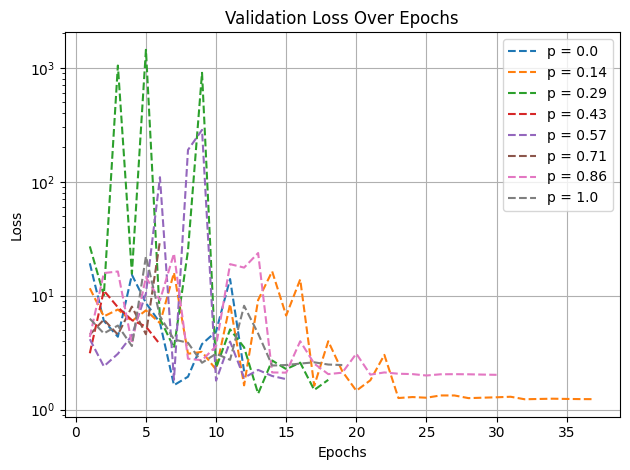

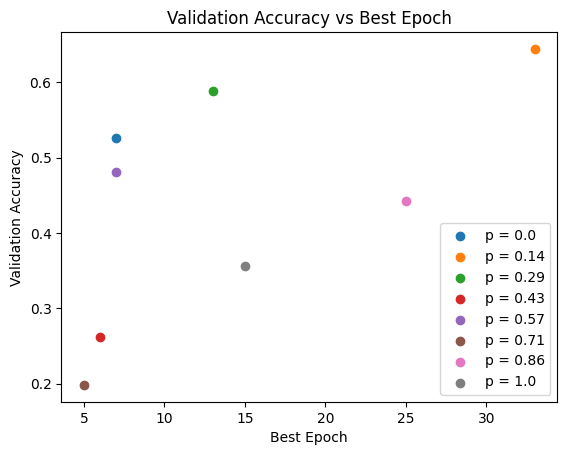

In [137]:
for p, history in zip(np.linspace(0,1,8), histories2):
    val_loss = history.history['val_loss']
    epochs = range(1, len(val_loss) + 1)
    plt.plot(epochs, val_loss, '--', label='p = ' + str(np.round(p,2)) )
plt.title('Validation Loss Over Epochs')
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
for i, (p, history) in enumerate(zip(np.linspace(0,1,8), histories2)):
    acc = [np.max(history.history['val_accuracy'])]
    be = [np.argmax(history.history['val_accuracy'])+1]
    plt.scatter(be, acc, label='p = ' + str(np.round(p,2)) )
plt.title('Validation Accuracy vs Best Epoch')
plt.xlabel('Best Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()

Wygląda więc na to, że lekki dropout pomaga naszemu modelowi! To dobra informacja. Oprócz tego accuracy na poziomie >0.6 nie wydaje się złym wynikiem dla trudnej klasyfikacji ~120 klas. 

Spróbuje teraz zająć się problemem skakania funkcji straty na zbiorze walidacyjnym. Pierwszym narzucającym się podejściem jest znormalizowanie każdego wkładu przez ilość tychże klas w zbiorze treningowym i walidacyjnym.

W tym celu użuje customowo napisane metryki 'Metryka'. Realizować ona będzie 'ważone' sparse_cross_entropy

In [9]:
for i in range(len(T_counts)):
    T_counts[i]=1/T_counts[i] #to będą wagi
    V_counts[i]=1/V_counts[i] #to będą wagi
train_vector = tf.constant(T_counts, dtype=tf.float32)
val_vector = tf.constant(V_counts, dtype=tf.float32)

To teraz callbacki na kolejny trening

In [10]:
early_stop = EarlyStopping(
    monitor='val_V_loss',     
    patience=8,            
    restore_best_weights=True,  
    verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_V_loss',     
    factor=0.5,              
    patience=2,              
    min_lr=1e-6,             
    verbose=1
)

Wytrenujmy teraz model z customową metryką

In [12]:
%%time
T_loss = Metryka(train_vector)
V_loss = Metryka(val_vector)
V_loss.__name__ = 'V_loss' 
p=0.15
with tf.device('/GPU:0'):
        pm = (p, True, True, 121)
        model = Model(*pm)
        model.compile(
            optimizer='adam',
            loss=T_loss,
            metrics = [V_loss, 'accuracy']
        )
        history = model.fit(
            T_ds,
            validation_data=V_ds,
            epochs=50,
            callbacks=[early_stop, reduce_lr],
            verbose=1,
        )
        print('Achieved validation accuracy of: ' + str(max(history.history['val_accuracy'])))
        # Save metrics to CSV
        df = pd.DataFrame(history.history)
        df.to_csv(f"dropout_{p:.2f}_training_log2.csv", index=False)
        print(f">>> Metrics saved to: dropout_{p:.2f}_training_log4.csv")

Epoch 1/50
2918/2918 [==============================] - 88s 30ms/step - loss: 0.0193 - V_loss: 0.2698 - accuracy: 0.1913 - val_loss: 0.0585 - val_V_loss: 0.7519 - val_accuracy: 0.0679 - lr: 0.0010
Epoch 2/50
2918/2918 [==============================] - 87s 29ms/step - loss: 0.0150 - V_loss: 0.2094 - accuracy: 0.3089 - val_loss: 0.0336 - val_V_loss: 0.4309 - val_accuracy: 0.1159 - lr: 0.0010
Epoch 3/50
2918/2918 [==============================] - 86s 29ms/step - loss: 0.0134 - V_loss: 0.1877 - accuracy: 0.3644 - val_loss: 0.0140 - val_V_loss: 0.1794 - val_accuracy: 0.3550 - lr: 0.0010
Epoch 4/50
2918/2918 [==============================] - 87s 30ms/step - loss: 0.0124 - V_loss: 0.1738 - accuracy: 0.4051 - val_loss: 0.2586 - val_V_loss: 3.3203 - val_accuracy: 0.0720 - lr: 0.0010
Epoch 5/50
2917/2918 [============================>.] - ETA: 0s - loss: 0.0116 - V_loss: 0.1629 - accuracy: 0.4349
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
2918/2918 [==========

Wow! Wydaje się działać całkiem okey. Co prawda val_loss ciągle skacze, ale model: uczy się długo i osiąga naprawdę niezłe wyniki. Prawdopodobnie w tym momencie należałoby zrobić porządny gridsearch z różnymi wartościami dropoutu, spatial dropoutu i regularyzacji ale jako, że szkolę to na własnej karcie graficznej to oszczędze jej tych parunastu godzin pracy...

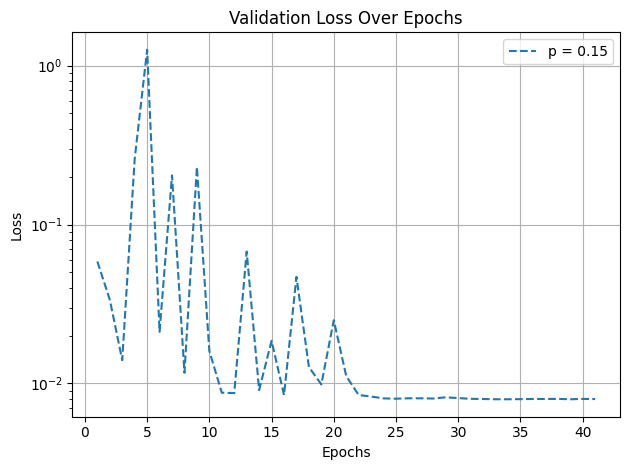

In [13]:
val_loss = history.history['val_loss']
epochs = range(1, len(val_loss) + 1)
plt.plot(epochs, val_loss, '--', label='p = ' + str(np.round(p,2)) )
plt.title('Validation Loss Over Epochs')
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Val loss niestey ciągle skacze, ale koniec końców wynik wydaje się być niezły

Znajdźmy macierz pomyłek

In [15]:
y_true = []
y_pred = []

for x_batch, y_batch in V_ds:
    preds = model.predict(x_batch, verbose=0)
    pred_labels = np.argmax(preds, axis=1)
    
    y_true.extend(y_batch.numpy())
    y_pred.extend(pred_labels)

In [26]:
y_true = np.array(y_true)
y_pred = np.array(y_pred)

#Liczenie klas po raz kolejny
class_counts = np.bincount(y_true, minlength=120)
class_names = np.unique(y_true)
sorted_indices = np.argsort(-class_counts)  # do dołu
sorted_class_names = class_names[sorted_indices]
# macierz pomyłek
cm = confusion_matrix(y_true, y_pred, labels=sorted_indices)

In [17]:
cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

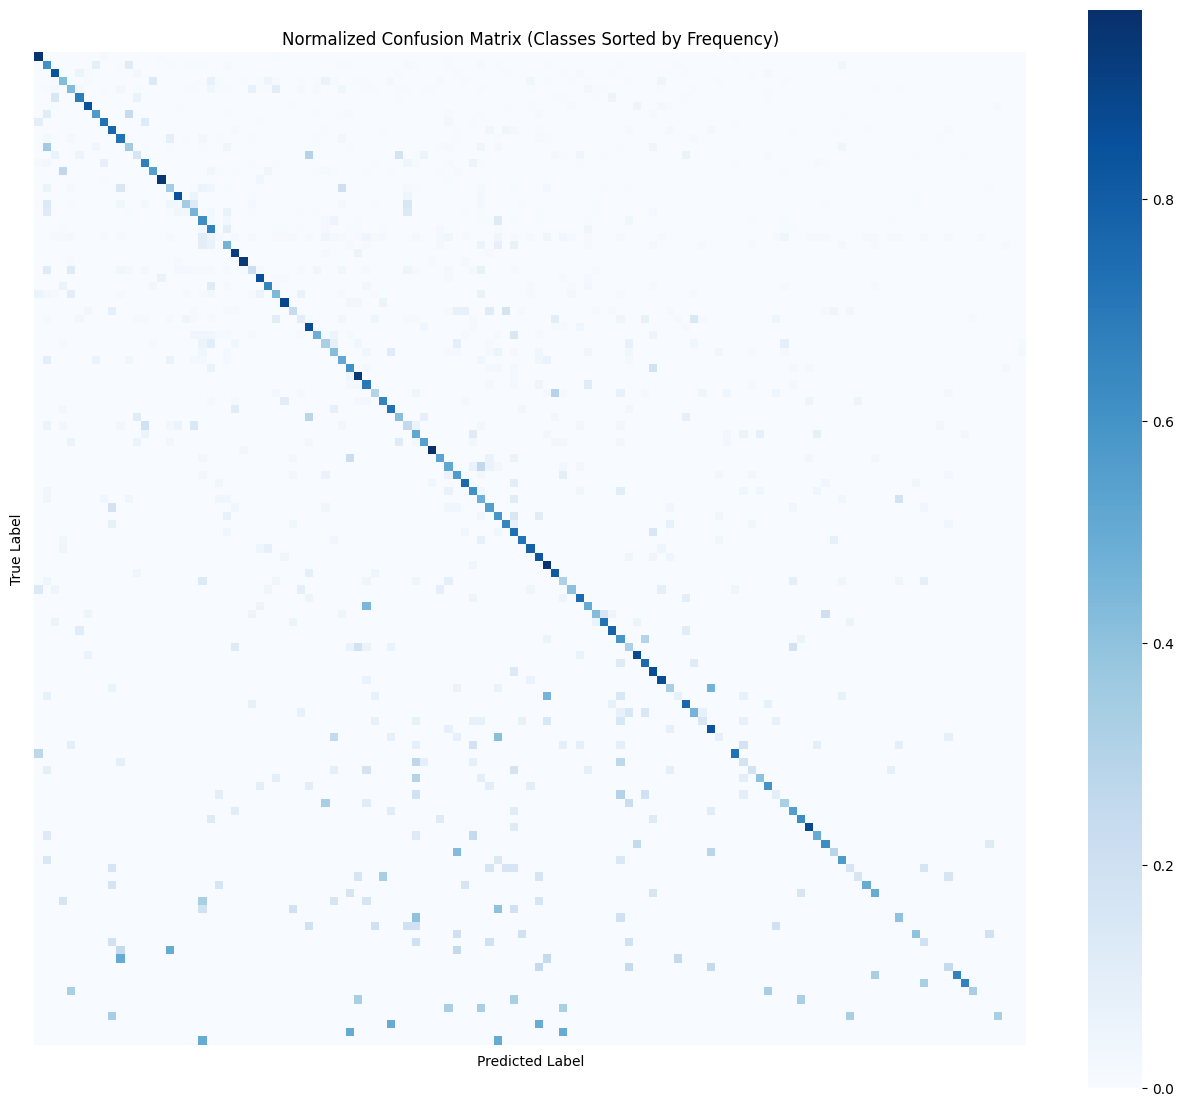

In [18]:
plt.figure(figsize=(16, 14))
sns.heatmap(cm_normalized, cmap="Blues", square=True, xticklabels=False, yticklabels=False)
plt.title("Normalized Confusion Matrix (Classes Sorted by Frequency)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Na powyższej macierzy klasy uszeregowano zgodnie z częstotliwością występowania klas. Obserwujemy całkiem niezłe wyniki dla dużej ilości klas i wręcz fatalne dla innych... 
Powinno to być ładnie widać na histogramie diagonali macierzy pomyłek tj. histogramu wartości accuracy na klasę

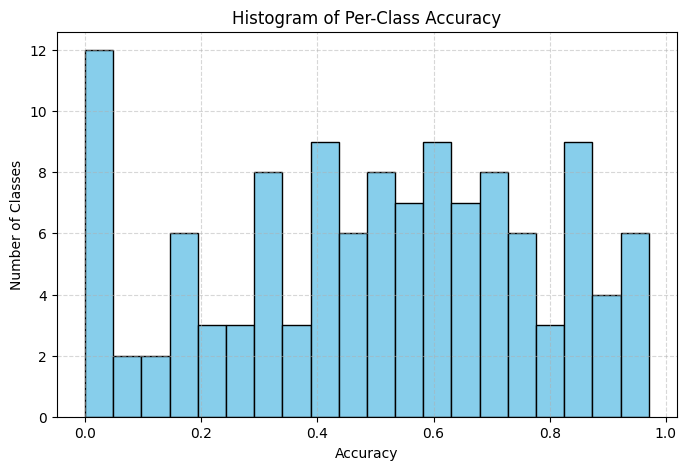

In [19]:
diagonal = np.diag(cm_normalized)
plt.figure(figsize=(8, 5))
plt.hist(diagonal, bins=20, color='skyblue', edgecolor='black')
plt.title("Histogram of Per-Class Accuracy")
plt.xlabel("Accuracy")
plt.ylabel("Number of Classes")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Jak sie to ma do częstości klas? Narysuje każdą klasę w układzie współrzędnych (częstość występowania, accuracy)

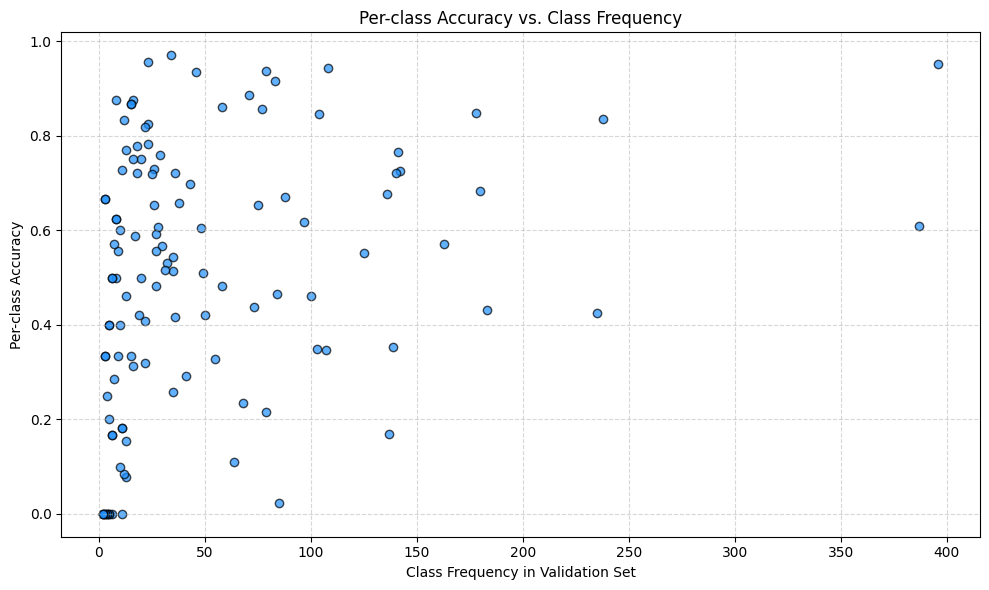

In [22]:
sorted_counts = class_counts[sorted_indices]
plt.figure(figsize=(10, 6))
plt.scatter(sorted_counts, diagonal, alpha=0.7, color='dodgerblue', edgecolors='k')
plt.title("Per-class Accuracy vs. Class Frequency")
plt.xlabel("Class Frequency in Validation Set")
plt.ylabel("Per-class Accuracy")
plt.grid(True, linestyle='--', alpha=0.5)

# Dodaj średnią linię accuracy
plt.tight_layout()
plt.show()

Widać, że wszystkie klasy z accuracy dookoła zera cechuje bardzo mała ilość przypadków w zbiorze walidacyjnym. Prawdopodobnie przypadki na walidacyjnym są znacznie różne od przypadków w treningowym co nie jest dziwne patrząc na to ile tych przypadków jest...

To co może być interesujące to zajrzenie w klasyfikacje programu. Które planktony są do siebie podobne?

Pobawmy się trochę w clustering!
Macierz pomyłek mówi nam o tym jak podobne są do siebie klasy (przynajmniej według programu). Możemy więc myśleć sobie o 1-macierz pomyłek jako o macierzy odległości między klasami co pozwala wrzucić teraz te dane do algorytmów clusteringu. 

In [23]:
#Zamieńmy macierz pomyłek na macierz odległości
sim = (cm_normalized + cm_normalized.T) / 2  #symetryzacja bo większość algorytmów tego wymaga
np.fill_diagonal(sim, 1.0)  # sam ze sobą powinno 

#1-podobność = dystans
dist = 1.0 - sim

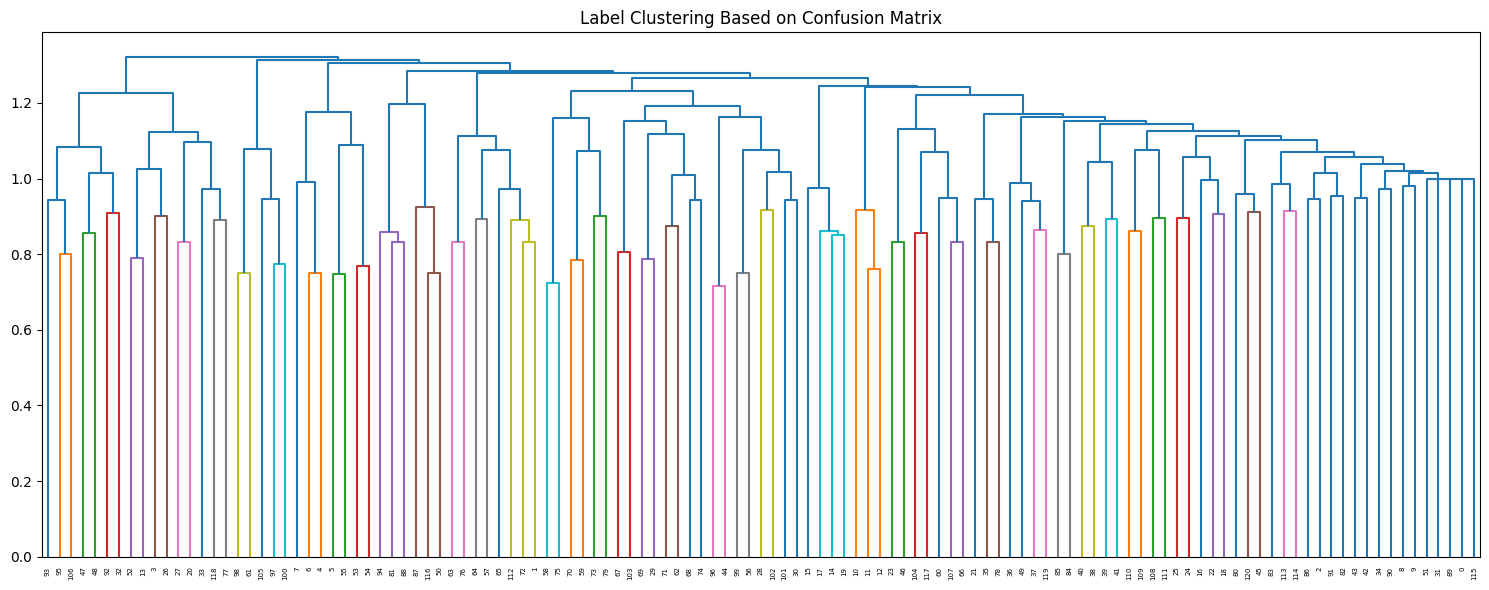

In [27]:
dist_vec = squareform(dist)

# Perform hierarchical clustering
link = linkage(dist_vec, method='ward')

# Dendrogram
plt.figure(figsize=(15, 6))
dendrogram(link, labels=sorted_class_names, leaf_rotation=90)
plt.title("Label Clustering Based on Confusion Matrix")
plt.tight_layout()
plt.show()

Program znalazł troche sobie poklastrował. Widać, że pewne rodzaje planktonu są dla niego bardziej podobne.

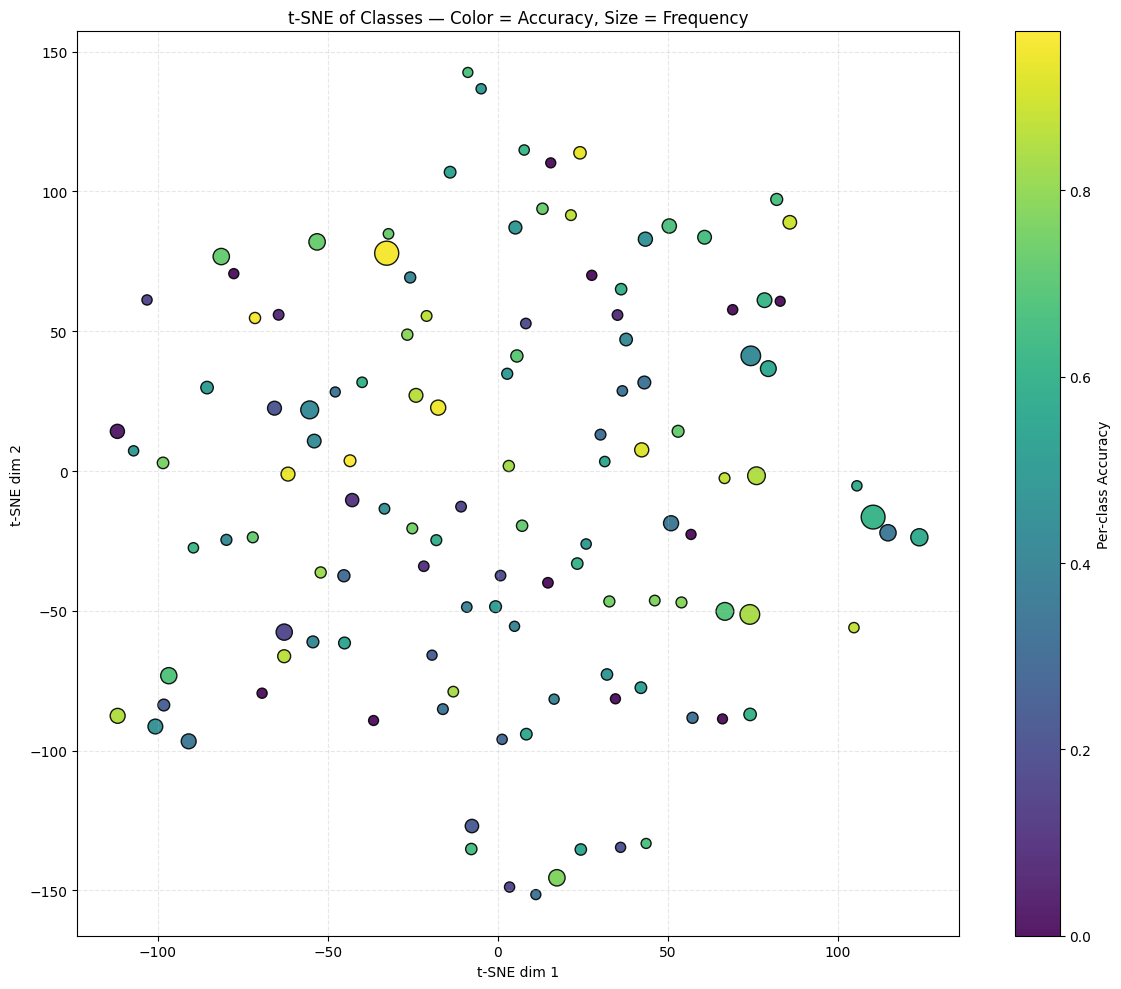

In [34]:
# Normalizacja
sizes = 50 + 250 * (sorted_counts / np.max(sorted_counts))  # scale from 50 to 300

# Normalizacja
norm = Normalize(vmin=0.0, vmax=1.0)
colors = diagonal

plt.figure(figsize=(12, 10))
scatter = plt.scatter(
    embedding[:, 0], embedding[:, 1],
    s=sizes, c=colors,
    cmap='viridis', alpha=0.9, edgecolor='black'
)


plt.colorbar(scatter, label="Per-class Accuracy")
plt.title("t-SNE of Classes — Color = Accuracy, Size = Frequency")
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

Tutaj mamy przybliżony rozkład podobieństwa punktów względem macierzy pomyłek w abstrakcyjnych współrzędnych. Kolorem oznaczono accuracy, wielkością kropki częstotliwość w zbiorze. Wydaje, się że widać troche podgrupek które algorytm często myli.

W następnym kroku przyjrzę się konkretnemu klastrowi

In [117]:
clusters = fcluster(link, t=40, criterion='maxclust')

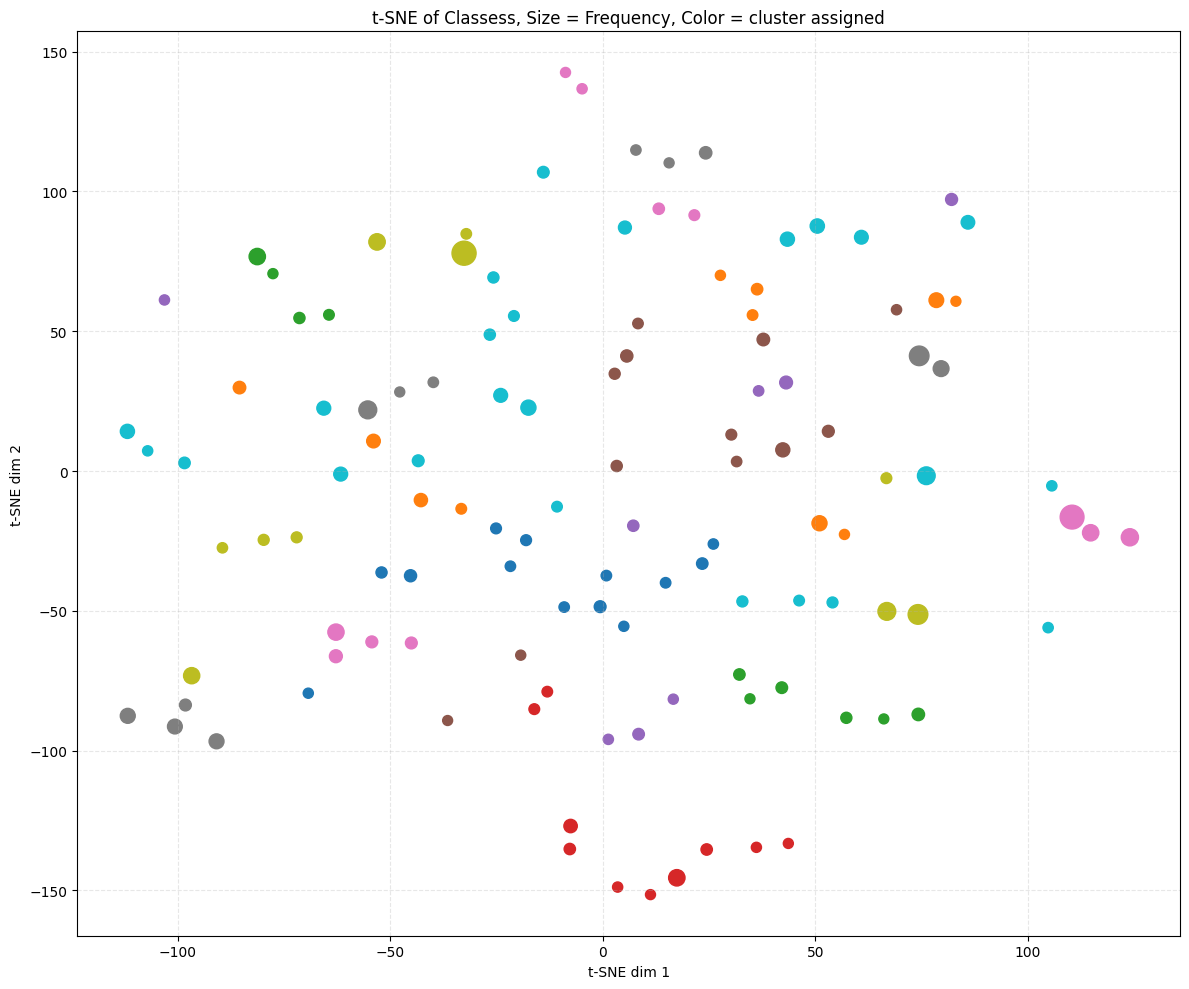

In [118]:
plt.figure(figsize=(12, 10))
plt.scatter(embedding[:, 0], embedding[:, 1], c=clusters, cmap='tab10', s=sizes)
plt.title("t-SNE of Classess, Size = Frequency, Color = cluster assigned")
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

Podział clusteringiem na rzekomo podobne klasy

In [120]:
clustered = [[] for _ in range(40)]
for i in range(0,121):
    clustered[clusters[i]-1].append(sorted_class_names[i])
decoded_clusters = []
for lista in clustered:
    decoded_clusters.append(label_encoder.inverse_transform(lista))
print(decoded_clusters[0])

['shrimp_zoea' 'shrimp_caridean' 'stomatopod']


In [121]:
# Save the entire model as an HDF5 file
model.save('path/to/save/model.h5')
model.save_weights('path/to/save/model_weights.h5')

In [122]:
import matplotlib.pyplot as plt
import math
from PIL import Image  # for loading images

def plot_single_cluster(encoded_cluster, decoded_cluster, V_data, V_labels):
    num_classes = len(encoded_cluster)
    cols = min(5, num_classes)
    rows = math.ceil(num_classes / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
    axes = axes.flatten() if num_classes > 1 else [axes]

    for i, (enc_label, dec_label) in enumerate(zip(encoded_cluster, decoded_cluster)):
        ax = axes[i];
        idx = V_labels.index(enc_label);
        image_path = V_data[idx];
        image = Image.open(image_path);
        plt.sca(ax);
        PlantktonPlot(image, dec_label);
        ax.set_title(dec_label);

    for j in range(num_classes, len(axes)):
        axes[j].axis('off')

    plt.suptitle("Cluster Visualization", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

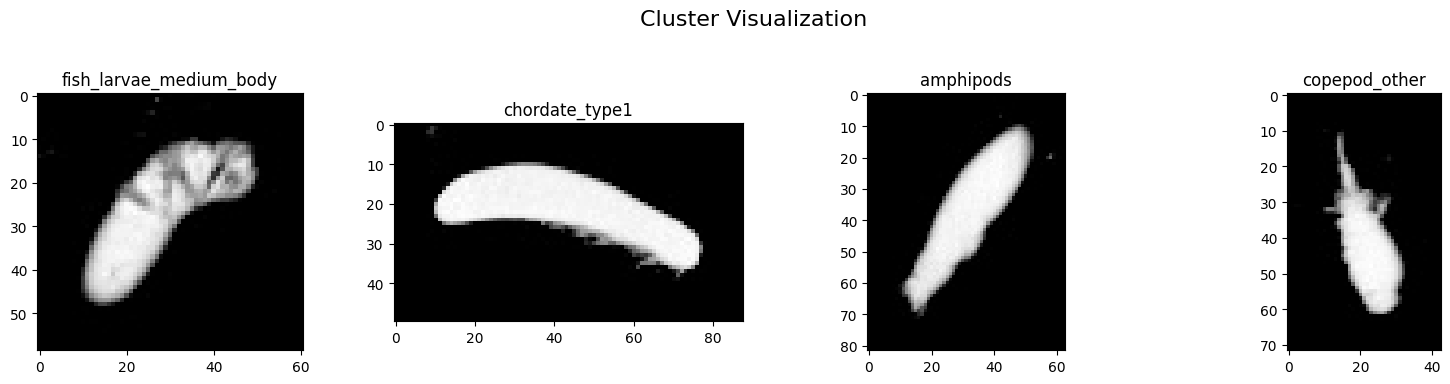

In [125]:
plot_single_cluster(clustered[2], decoded_clusters[2], V_data, V_labels)

Przykładowa klasa podobnych według modelu planktonów. Widać skąd model może się pomylić...

Następnym krokiem (którego tutaj nie załączam bo nic z niego nie wyszło) była próba wyszkolenia następującego algorytmy:
    1) z clusteringu dostaje informacje które zbiory są dla sieci 'podobne'. Mogę złączyć podobne do siebie klasy.
    2) uczę model klasyfikacji 40 klas uzyskanych poprzez powyższy proces (Model0) 
    3) Dostaje model w ktory w naturalny sposób grupuje próbki na podobne do siebie planktony
    4) Dla każdej z klas mogę teraz wytrenować minimodel 
Podejście to miałoby sens jeśli:


$ Accuracy(\text{Model0})\cdot\sum ClusterWeight(i) \cdot Accuracy(\text{Minimodel i}) > 0.6$

gdzie model weights zależy od liczebności przypadków w klastrze. 
Zrobiłem taki prototyp i dostałem 0.75 accuracy modelu0 i około 0.75 accuracy na minimodelach. W ten sposób osiągnąłbym więc accuracy rzędu ~0.56. 
Prawdopodobnie przy lepszej konstrukcji minimodeli, po solidnym gridsearchu można by mieć dobre wyniki

### Podsumowanie ###
Najlepszy wyszkolony model osiągnął accuracy ~0.6. Przy 120 klasach nie jest to wynik dramatyczny, ale nie jest też satysfakcjonujący. Niestety nie udało się poradzić odpowiednio z problemami małej ilości klas. Augmentacja pomogła w pewnym stopniu ale nie pozwoliła na świetne wyniki. Dataset ten nie jest jednak prosty (w 2015 był przedmiotem konkursu z pulą nagród 175 000 dolarów).
Wizualizacja danych umożliwiła lekki wgląd w działanie algorytmu, a dalsza analiza z pomoca algorytmów clusteringu umożliwiła spojrzenie na klasy planktonu które model uważa za podobne.